# Processing images and labels into chips

Planet imagery was originally processed into larger tiles of 2368 x 2358 pixels at a resolution of 0.000025$^\circ$. Labelling was undertaken on only a subset of each tile, corresponding to a 0.005$^\circ$ target (~550 m). For release, the imagery was cropped to the target box and resampled to make chips of 224x224 pixels, and labels were rasterized to the same dimensions. 

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import rioxarray as rxr
from datetime import datetime as dt
from makelabels import MakeLabels

## Setup

In [15]:
root_dir = os.environ["HOME"]
proj_dir = Path(root_dir) / "projects/lacunalabels"
data_dir = Path(root_dir) / "data"
chip_dir = Path(data_dir) / "labels/lacuna/images"
label_dir = Path(data_dir) / "labels/lacuna/labels"
image_dir = Path(os.path.dirname(root_dir)) / "data/imagery/planet/tiles"
log_file = str(Path(root_dir) / "logs/image-chipping-1")

for d in [chip_dir, label_dir]:
    if not os.path.isdir(d):
        os.makedirs(d)

### Catalogs

In [16]:
catalog = pd.read_csv(Path(proj_dir) /\
                      "data/interim/assignments_full_wtiles.csv")
chip_catalog = (
    catalog[["name", "image_date", "x", "y", "destfile"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [17]:
kwargs = {
    "src_dir": image_dir, 
    "dst_dir": chip_dir, 
    "src_col": "destfile",
    "date_col": "image_date",
    "w": 0.0025, 
    "rows": 224,
    "cols": 224, 
    "crs": "epsg:4326",
    "verbose": False,
    "overwrite": False
}
# def parallelize(row, function=mkl.image_chipper, args=kwargs): 
#     try:
#         result = function(row, **args)
#         return result
#     except Exception as e:
#         return result, str(e)

# rows = chip_catalog.to_dict(orient='records')
# with Pool() as pool:
#     results = pool.map(parallelize, rows)
#     makelabels.log_message("Completed run", verbose=False, logger=mkl.logger)

Initialize the class, with logging

In [18]:
mkl = MakeLabels(logfile=log_file)

Started dataset creation


In [6]:
%%time
catalogf = mkl.run_parallel_pool(
    chip_catalog.iloc[0:1000], mkl.image_chipper, kwargs
)  # Wall time: 2min 43s
catalogf = pd.DataFrame(catalogf)

Completed run
CPU times: user 107 ms, sys: 187 ms, total: 294 ms
Wall time: 2min 43s


In [19]:
%%time
catalogf = mkl.run_parallel_thread(
    chip_catalog, mkl.image_chipper, kwargs, 4
) # Wall time: 2min 35s
catalogf = pd.DataFrame(catalogf)

Completed run
CPU times: user 2.45 s, sys: 740 ms, total: 3.19 s
Wall time: 4.8 s


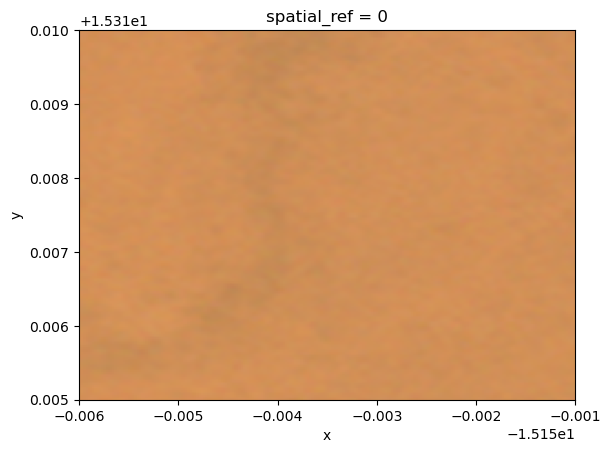

In [27]:
# i = 7
# rxr.open_rasterio(Path(chip_dir) / chip_list[i].image)[[2,1,0]].plot.imshow(vmin=0, vmax=3000)